https://machinelearning.wtf/terms/training-validation-test-datasets/  
https://deepchecks.com/evaluating-model-performance-using-validation-dataset-splits-and-cross-validation-techniques/  
https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati  



How to improve performance:  

Hyperparameter Tuning: Perform hyperparameter tuning for both the Linear SVC and Gradient Boosting classifiers. You can use techniques like grid search or random search to find the best combination of hyperparameters that maximize their performance on your dataset.

Class Imbalance: If your dataset suffers from class imbalance, apply techniques to handle it. You can try oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique).

Feature Engineering: Experiment with different text preprocessing techniques and try to extract more relevant features that might capture important patterns in the data. Additionally, consider exploring different word embeddings or fine-tuning the existing embeddings on your specific task.

Ensemble Methods: After hyperparameter tuning and handling class imbalance, consider creating an ensemble of the optimized Linear SVC and Gradient Boosting classifiers. Combining the strengths of both models through ensemble techniques can lead to further performance improvements.

Cross-Validation: Throughout the process, remember to use cross-validation to evaluate the models and avoid overfitting.

Error Analysis: Analyze the errors made by the optimized models on the validation set. This can provide valuable insights into specific areas where further improvements can be made.

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel,RFE 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [17]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [18]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [21]:
y=df['reason']
X = df[['narrative_tfidf', 'tfidf_title', 'tfidf_keywords', 'events_tfidf', 'entities']]

In [22]:
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_test shape: (6729, 5)
y_test shape: (6729,)


In [23]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_selected = X_train[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
config= {'ngram_range': (1,2), 'max_df':0.80, 'min_df': 0.01}  
vectorizer= TfidfVectorizer(**config)

In [24]:
def cross_validate_with_pipeline(pipeline, X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_true_labels = []
    all_predicted_labels = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        pipeline.fit(X_train_fold, y_train_fold)

        y_pred_train = pipeline.predict(X_train_fold)
        y_pred_val = pipeline.predict(X_val_fold)

        training_f1_macro = f1_score(y_train_fold, y_pred_train, average='macro')
        validation_f1_macro = f1_score(y_val_fold, y_pred_val, average='macro')

        print(f"Fold number: {fold}, Training F1 Macro: {training_f1_macro:.4f}, Validation F1 Macro: {validation_f1_macro:.4f}")

        all_true_labels.extend(y_val_fold)
        all_predicted_labels.extend(y_pred_val)

    return all_true_labels, all_predicted_labels


In [25]:
def plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels):
    # Generate the confusion matrix
    confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_labels)

    # Calculate the classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=[f'Class {label}' for label in class_labels])

    print("\nClassification Report:")
    print(class_report)

    # Plot the confusion matrix
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)
    plt.show()
    print('\n')

# LinearSVC

before: f1= 0.45, accuracy=0.64  
multiple param_grids because some hyperparameters are not compatible:
* l1 only works with squared_hinge and dual=False
* l2 works with both hinge and squared_hinge, but:
* l2 and hinge only work with dual=True
* l2 and squared_hinge work with both dual=True or dual=False
* dual = True if number of features > number of examples 
* C>0

<span style="color:white; font-size:18px;background-color:red"> HYPERPARAMETER TUNING </span>  

In [11]:
# Define multiple hyperparameter grids
param_grid_1 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l1'],
    'classifier__dual': [False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True, False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

In [11]:
combined_param_grid = list(itertools.product(*param_grids))
total_combinations = len(combined_param_grid)
total_combinations

125

In [12]:
model= LinearSVC(random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,  
    scoring='f1_macro', 
    cv=kf,
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_selected, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.452
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 10.0}


Fold number: 1, Training F1 Macro: 0.6182, Validation F1 Macro: 0.4435
Fold number: 2, Training F1 Macro: 0.6060, Validation F1 Macro: 0.4706
Fold number: 3, Training F1 Macro: 0.6021, Validation F1 Macro: 0.4485
Fold number: 4, Training F1 Macro: 0.6092, Validation F1 Macro: 0.4397
Fold number: 5, Training F1 Macro: 0.6042, Validation F1 Macro: 0.4588

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.59      0.58      5576
     Class 1       0.28      0.11      0.15      1553
     Class 2       0.72      0.81      0.76      7510
     Class 3       0.37      0.28      0.32      1062

    accuracy                           0.63     15701
   macro avg       0.48      0.45      0.45     15701
weighted avg       0.60      0.63      0.61     15701

Confusion Matrix:


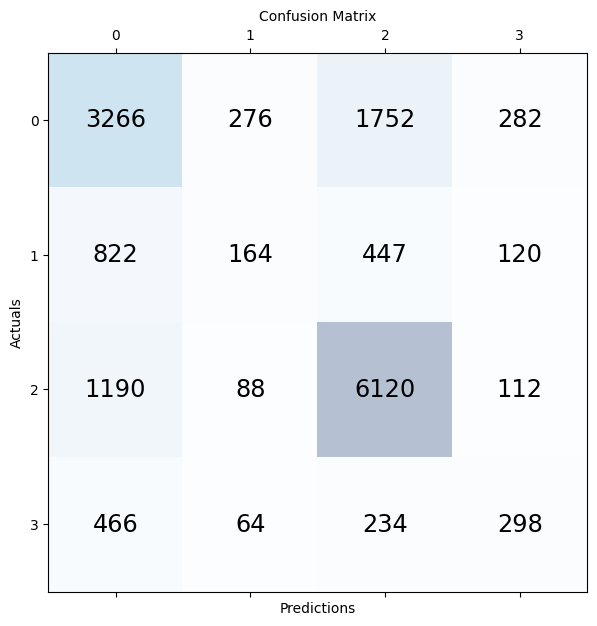

In [33]:
params={'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': True, 'C': 10.0}
model= LinearSVC(**params, random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE </span>  

Fold number: 1, Training F1 Macro: 0.6182, Validation F1 Macro: 0.4383
Fold number: 2, Training F1 Macro: 0.6037, Validation F1 Macro: 0.4426
Fold number: 3, Training F1 Macro: 0.6084, Validation F1 Macro: 0.4474
Fold number: 4, Training F1 Macro: 0.6119, Validation F1 Macro: 0.4358
Fold number: 5, Training F1 Macro: 0.6134, Validation F1 Macro: 0.4474

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.56      0.40      0.47      5576
     Class 1       0.20      0.33      0.25      1553
     Class 2       0.76      0.71      0.73      7510
     Class 3       0.25      0.47      0.32      1062

    accuracy                           0.55     15701
   macro avg       0.44      0.48      0.44     15701
weighted avg       0.60      0.55      0.56     15701

Confusion Matrix:


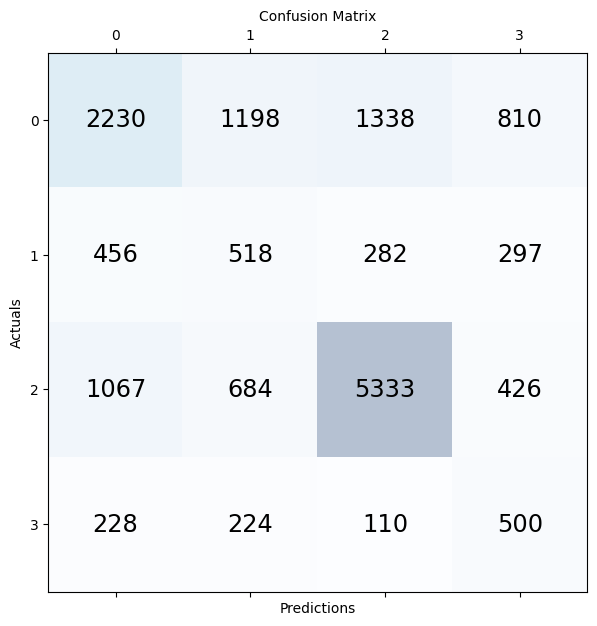

In [44]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

model= LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote), 
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

In each fold of your cross-validation loop, you're fitting the model on the training data (including SMOTE) and evaluating it on the validation data. You can access the performance metrics (e.g., accuracy, F1-score) for both the training and validation sets. Overfitting is indicated if you consistently observe a significant gap between the training accuracy and the validation accuracy. In other words, if the model performs much better on the training data than on the validation data across all folds, it suggests overfitting.

<span style="color:white; font-size:18px;background-color:red"> SMOTE + HT </span>  

In [34]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Define the model with hyperparameter search space
model = LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids,
    scoring='f1_macro',
    cv=kf,
    n_iter=50,  
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Fit the RandomizedSearchCV on your data
random_search.fit(X_train_selected, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.482
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 0.01}


Fold number: 1, Training F1 Macro: 0.5351, Validation F1 Macro: 0.4726
Fold number: 2, Training F1 Macro: 0.5278, Validation F1 Macro: 0.4744
Fold number: 3, Training F1 Macro: 0.5307, Validation F1 Macro: 0.4874
Fold number: 4, Training F1 Macro: 0.5324, Validation F1 Macro: 0.4840
Fold number: 5, Training F1 Macro: 0.5319, Validation F1 Macro: 0.4898

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.63      0.35      0.45      5576
     Class 1       0.26      0.38      0.31      1553
     Class 2       0.75      0.82      0.78      7510
     Class 3       0.28      0.59      0.38      1062

    accuracy                           0.59     15701
   macro avg       0.48      0.53      0.48     15701
weighted avg       0.63      0.59      0.59     15701

Confusion Matrix:


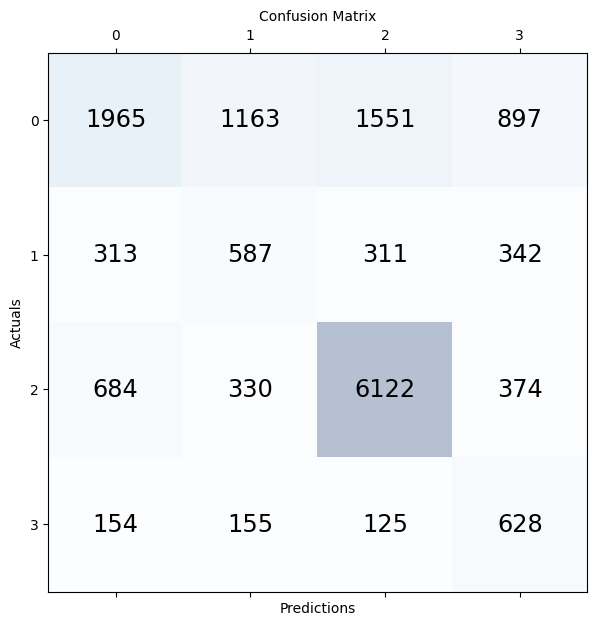

In [43]:
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS </span>  

Fold number: 1, Training F1 Macro: 0.6400, Validation F1 Macro: 0.4581
Fold number: 2, Training F1 Macro: 0.6250, Validation F1 Macro: 0.4758
Fold number: 3, Training F1 Macro: 0.6257, Validation F1 Macro: 0.4607
Fold number: 4, Training F1 Macro: 0.6369, Validation F1 Macro: 0.4563
Fold number: 5, Training F1 Macro: 0.6270, Validation F1 Macro: 0.4795

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.49      0.53      5576
     Class 1       0.22      0.24      0.23      1553
     Class 2       0.75      0.76      0.76      7510
     Class 3       0.28      0.45      0.35      1062

    accuracy                           0.59     15701
   macro avg       0.46      0.49      0.47     15701
weighted avg       0.61      0.59      0.60     15701

Confusion Matrix:


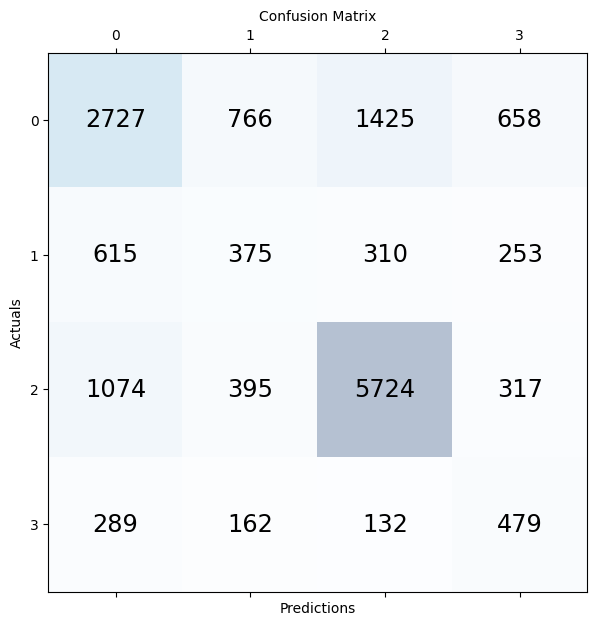

In [45]:
model= LinearSVC(class_weight='balanced', random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + HT</span>  

In [47]:
model= LinearSVC(class_weight='balanced',random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,  
    scoring='f1_macro', 
    cv=kf,
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_selected, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.495
Best Hyperparameters: {'classifier__penalty': 'l1', 'classifier__max_iter': 7000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 0.1}


Fold number: 1, Training F1 Macro: 0.5389, Validation F1 Macro: 0.4785
Fold number: 2, Training F1 Macro: 0.5300, Validation F1 Macro: 0.4931
Fold number: 3, Training F1 Macro: 0.5334, Validation F1 Macro: 0.4992
Fold number: 4, Training F1 Macro: 0.5357, Validation F1 Macro: 0.4949
Fold number: 5, Training F1 Macro: 0.5351, Validation F1 Macro: 0.5106

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.50      0.55      5576
     Class 1       0.32      0.21      0.25      1553
     Class 2       0.74      0.83      0.78      7510
     Class 3       0.31      0.52      0.39      1062

    accuracy                           0.63     15701
   macro avg       0.50      0.52      0.50     15701
weighted avg       0.63      0.63      0.62     15701

Confusion Matrix:


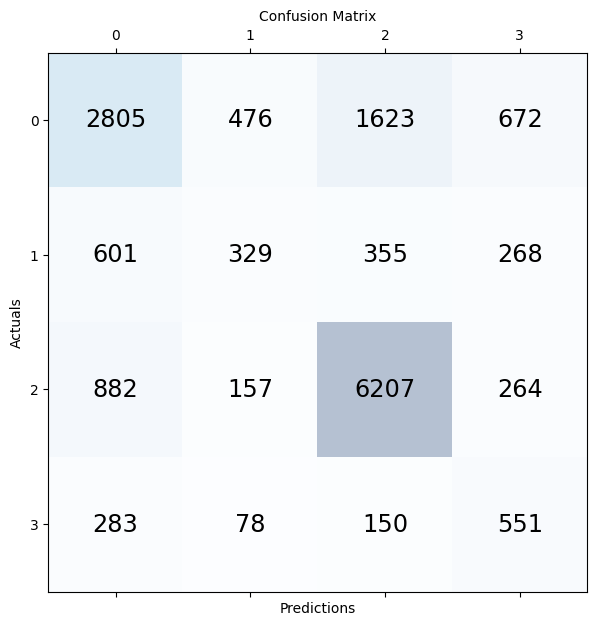

In [48]:
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + SMOTE +HT </span>  

In [26]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Define the model with hyperparameter search space
model= LinearSVC(class_weight='balanced',random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids,
    scoring='f1_macro',
    cv=kf,
    n_iter=50,  
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Fit the RandomizedSearchCV on your data
random_search.fit(X_train_selected, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.482
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 0.01}


In [28]:
print(best_model.named_steps['classifier'].get_params())

{'C': 0.01, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 6000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}


Fold number: 1, Training F1 Macro: 0.5351, Validation F1 Macro: 0.4726
Fold number: 2, Training F1 Macro: 0.5278, Validation F1 Macro: 0.4744
Fold number: 3, Training F1 Macro: 0.5307, Validation F1 Macro: 0.4874
Fold number: 4, Training F1 Macro: 0.5324, Validation F1 Macro: 0.4840
Fold number: 5, Training F1 Macro: 0.5319, Validation F1 Macro: 0.4898

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.63      0.35      0.45      5576
     Class 1       0.26      0.38      0.31      1553
     Class 2       0.75      0.82      0.78      7510
     Class 3       0.28      0.59      0.38      1062

    accuracy                           0.59     15701
   macro avg       0.48      0.53      0.48     15701
weighted avg       0.63      0.59      0.59     15701

Confusion Matrix:


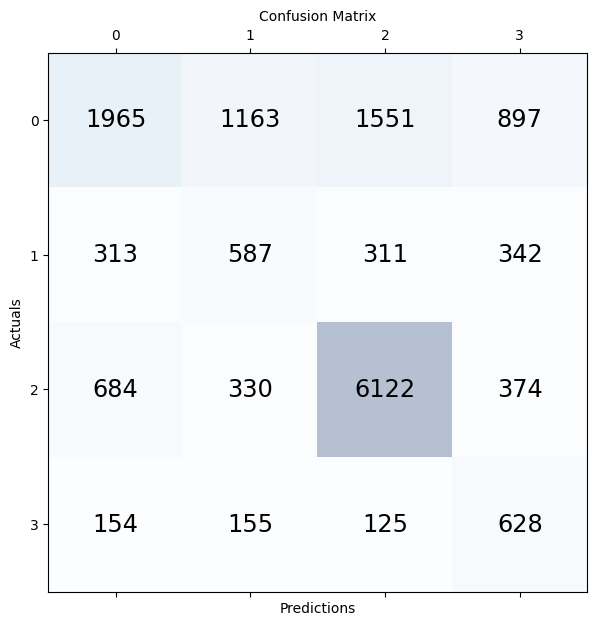

In [29]:
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + SMOTE </span>  

Fold number: 1, Training F1 Macro: 0.5351, Validation F1 Macro: 0.4726
Fold number: 2, Training F1 Macro: 0.5278, Validation F1 Macro: 0.4744
Fold number: 3, Training F1 Macro: 0.5307, Validation F1 Macro: 0.4874
Fold number: 4, Training F1 Macro: 0.5324, Validation F1 Macro: 0.4840
Fold number: 5, Training F1 Macro: 0.5319, Validation F1 Macro: 0.4898

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.63      0.35      0.45      5576
     Class 1       0.26      0.38      0.31      1553
     Class 2       0.75      0.82      0.78      7510
     Class 3       0.28      0.59      0.38      1062

    accuracy                           0.59     15701
   macro avg       0.48      0.53      0.48     15701
weighted avg       0.63      0.59      0.59     15701

Confusion Matrix:


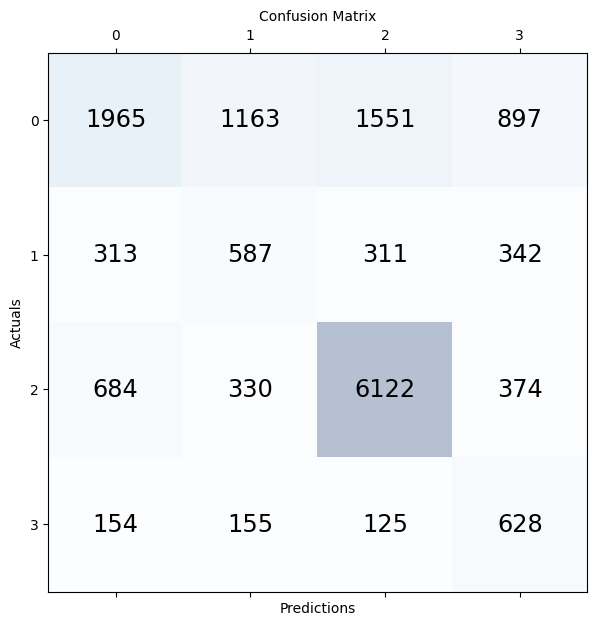

In [32]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')
params={'penalty': 'l1', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.1}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote), 
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> L1 REGULARIZATION </span>  

Fold number: 1, Training F1 Macro: 0.5858, Validation F1 Macro: 0.4432
Fold number: 2, Training F1 Macro: 0.5728, Validation F1 Macro: 0.4622
Fold number: 3, Training F1 Macro: 0.5715, Validation F1 Macro: 0.4484
Fold number: 4, Training F1 Macro: 0.5798, Validation F1 Macro: 0.4398
Fold number: 5, Training F1 Macro: 0.5744, Validation F1 Macro: 0.4452
Number of features before: 1240, number of features after: 1219

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.61      0.59      5576
     Class 1       0.30      0.08      0.13      1553
     Class 2       0.71      0.83      0.77      7510
     Class 3       0.42      0.24      0.31      1062

    accuracy                           0.64     15701
   macro avg       0.50      0.44      0.45     15701
weighted avg       0.60      0.64      0.61     15701

Confusion Matrix:


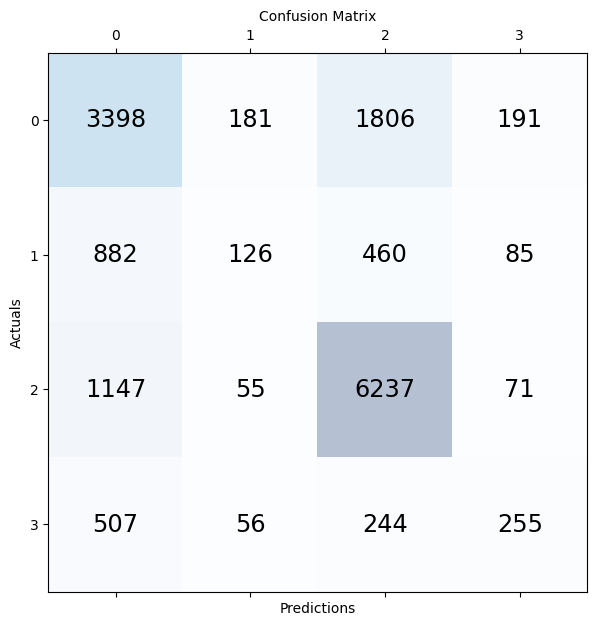

In [50]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classification', LinearSVC(random_state=42))
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)

selected_features = pipeline.named_steps['feature_selection'].get_support()
num_selected_features = np.sum(selected_features)
num_features_before=len(vectorizer.get_feature_names_out())
print(f'Number of features before: {num_features_before}, number of features after: {num_selected_features}')

plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> L1 REGULARIZATION + HT </span>  

In [57]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', LinearSVC(random_state=42))
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,  
    scoring='f1_macro', 
    cv=kf,
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_selected, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.451
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 10.0}


Fold number: 1, Training F1 Macro: 0.6166, Validation F1 Macro: 0.4418
Fold number: 2, Training F1 Macro: 0.6064, Validation F1 Macro: 0.4717
Fold number: 3, Training F1 Macro: 0.6039, Validation F1 Macro: 0.4432
Fold number: 4, Training F1 Macro: 0.6094, Validation F1 Macro: 0.4434
Fold number: 5, Training F1 Macro: 0.6032, Validation F1 Macro: 0.4551

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.59      0.58      5576
     Class 1       0.28      0.11      0.15      1553
     Class 2       0.71      0.82      0.76      7510
     Class 3       0.36      0.27      0.31      1062

    accuracy                           0.63     15701
   macro avg       0.48      0.45      0.45     15701
weighted avg       0.60      0.63      0.61     15701

Confusion Matrix:


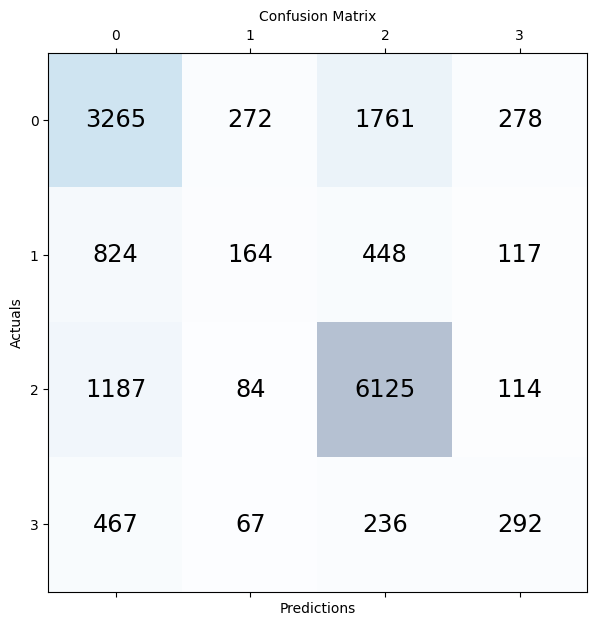

In [58]:
# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + L1 REGULARIZATION </span>  

Fold number: 1, Training F1 Macro: 0.5389, Validation F1 Macro: 0.4785
Fold number: 2, Training F1 Macro: 0.5300, Validation F1 Macro: 0.4931
Fold number: 3, Training F1 Macro: 0.5332, Validation F1 Macro: 0.4993
Fold number: 4, Training F1 Macro: 0.5357, Validation F1 Macro: 0.4949
Fold number: 5, Training F1 Macro: 0.5351, Validation F1 Macro: 0.5106

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.50      0.55      5576
     Class 1       0.32      0.21      0.25      1553
     Class 2       0.74      0.83      0.78      7510
     Class 3       0.31      0.52      0.39      1062

    accuracy                           0.63     15701
   macro avg       0.50      0.52      0.50     15701
weighted avg       0.63      0.63      0.62     15701

Confusion Matrix:


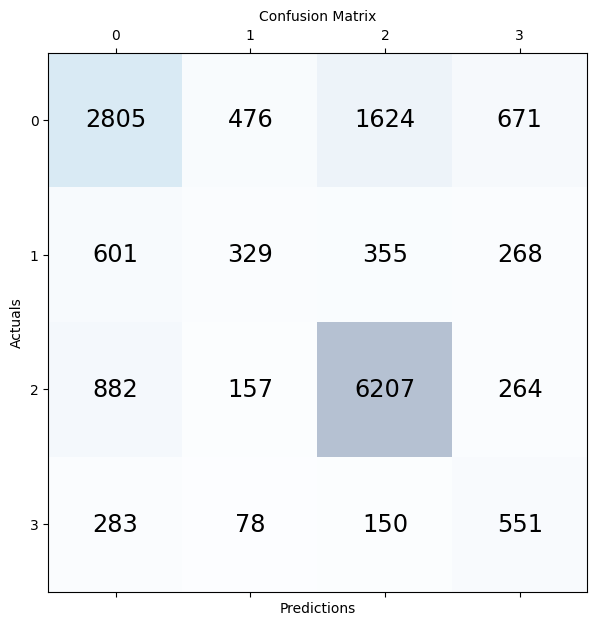

In [37]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

params={'penalty': 'l1', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.1}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

Fold number: 1, Training F1 Macro: 0.6468, Validation F1 Macro: 0.4476
Fold number: 2, Training F1 Macro: 0.6303, Validation F1 Macro: 0.4672
Fold number: 3, Training F1 Macro: 0.6338, Validation F1 Macro: 0.4480
Fold number: 4, Training F1 Macro: 0.6421, Validation F1 Macro: 0.4376
Fold number: 5, Training F1 Macro: 0.6366, Validation F1 Macro: 0.4666

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.48      0.52      5576
     Class 1       0.22      0.25      0.23      1553
     Class 2       0.75      0.74      0.75      7510
     Class 3       0.25      0.42      0.32      1062

    accuracy                           0.58     15701
   macro avg       0.45      0.47      0.45     15701
weighted avg       0.60      0.58      0.59     15701

Confusion Matrix:


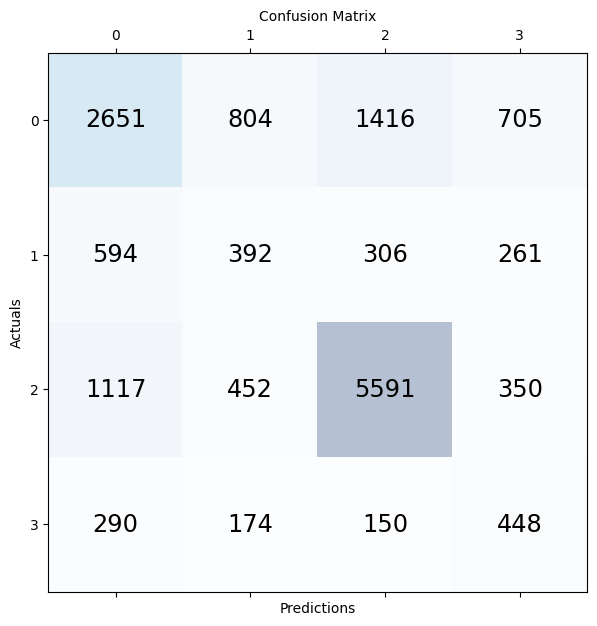

In [38]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

params={'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE + L1 REGULARIZATION </span>  

Fold number: 1, Training F1 Macro: 0.5477, Validation F1 Macro: 0.4634
Fold number: 2, Training F1 Macro: 0.5458, Validation F1 Macro: 0.4738
Fold number: 3, Training F1 Macro: 0.5467, Validation F1 Macro: 0.4771
Fold number: 4, Training F1 Macro: 0.5503, Validation F1 Macro: 0.4670
Fold number: 5, Training F1 Macro: 0.5481, Validation F1 Macro: 0.4841

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.37      0.46      5576
     Class 1       0.23      0.39      0.29      1553
     Class 2       0.77      0.77      0.77      7510
     Class 3       0.27      0.57      0.37      1062

    accuracy                           0.58     15701
   macro avg       0.47      0.52      0.47     15701
weighted avg       0.63      0.58      0.59     15701

Confusion Matrix:


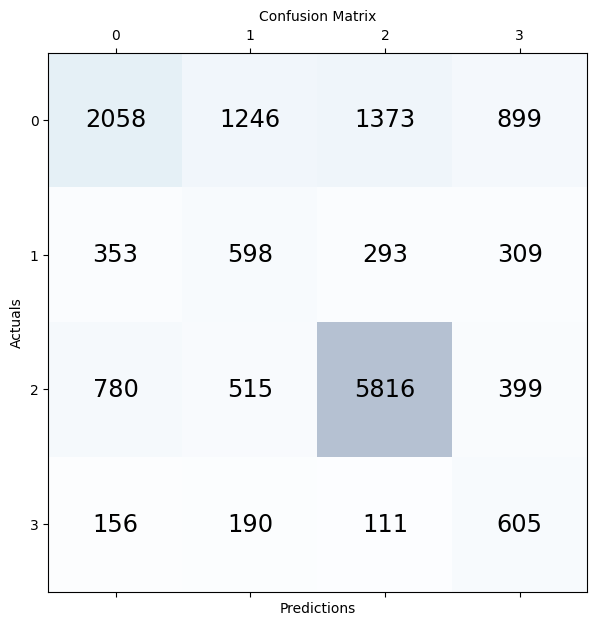

In [12]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

params={'penalty': 'l1', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.1}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('smote', smote),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CHI-2 FEATURE SELECTION + HT</span>  

In [39]:
num_features_before=len(vectorizer.get_feature_names_out())
num_features_before

1240

Highest F1 Score: 0.4529 (k=1042)


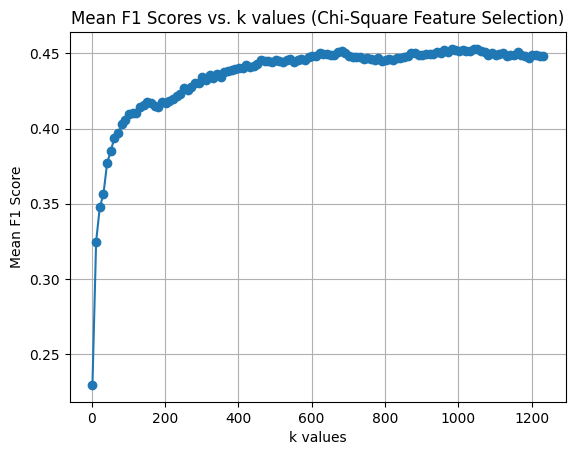

In [18]:
model = LinearSVC(random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectKBest(score_func=chi2)),
    ('classifier', model)])

k_values = np.arange(2, 1240, 10)

mean_f1_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each k value and calculate cross-validated F1 scores
for k in k_values:
    pipeline.named_steps['feature_selection'].set_params(k=k)  
    f1_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=kf, scoring='f1_macro')
    mean_f1 = np.mean(f1_scores)
    mean_f1_scores.append(mean_f1)

# Find the index of the highest mean F1 score
best_k_index = np.argmax(mean_f1_scores)

# Get the best mean F1 score and corresponding k value
best_mean_f1 = mean_f1_scores[best_k_index]
best_k = k_values[best_k_index]

# Print the results
print(f"Highest F1 Score: {best_mean_f1:.4f} (k={best_k})")
# Finally, plot the mean F1 scores against the k values
plt.plot(k_values, mean_f1_scores, marker='o')
plt.title('Mean F1 Scores vs. k values (Chi-Square Feature Selection)')
plt.xlabel('k values')
plt.ylabel('Mean F1 Score')
plt.grid(True)
plt.show()

Fold number: 1, Training F1 Macro: 0.5654, Validation F1 Macro: 0.4546
Fold number: 2, Training F1 Macro: 0.5609, Validation F1 Macro: 0.4624
Fold number: 3, Training F1 Macro: 0.5578, Validation F1 Macro: 0.4609
Fold number: 4, Training F1 Macro: 0.5601, Validation F1 Macro: 0.4414
Fold number: 5, Training F1 Macro: 0.5555, Validation F1 Macro: 0.4452

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.62      0.60      5576
     Class 1       0.33      0.07      0.12      1553
     Class 2       0.71      0.83      0.77      7510
     Class 3       0.46      0.25      0.32      1062

    accuracy                           0.64     15701
   macro avg       0.52      0.44      0.45     15701
weighted avg       0.61      0.64      0.61     15701

Confusion Matrix:


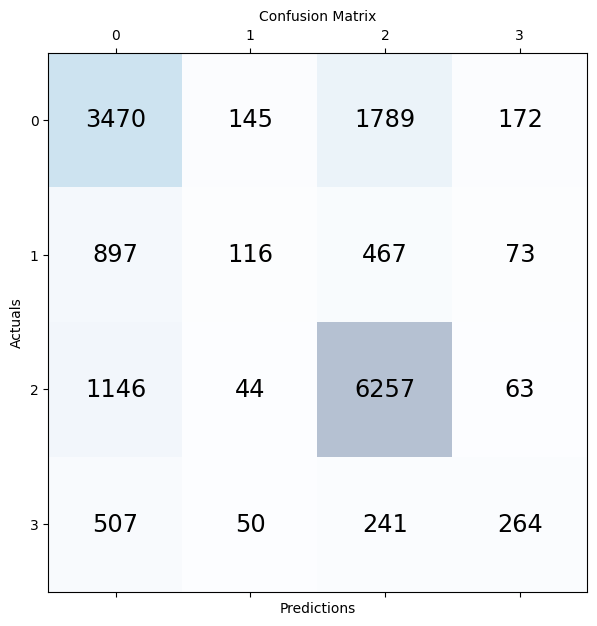

In [19]:
model= LinearSVC(random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectKBest(score_func=chi2, k=best_k)),
    ('classifier', model)])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

In [12]:
model= LinearSVC(random_state=42)
param_grid_1 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l1'],
    'classifier__dual': [False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000],
    'feature_selection__k':list(range(2, 1240, 10))
}

param_grid_2 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000],
    'feature_selection__k': list(range(2, 1240, 10))
}

param_grid_3 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True, False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000],
    'feature_selection__k': list(range(2, 1240, 10))
}
param_grids = [param_grid_1, param_grid_2, param_grid_3]

In [13]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectKBest(score_func=chi2)),
    ('classifier', model)])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,
    scoring='f1_macro',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=3
)

random_search.fit(X_train_selected, y_train)  
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.453
Best Hyperparameters: {'feature_selection__k': 1042, 'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 100.0}


In [14]:
best_model.named_steps['feature_selection']

SelectKBest(k=1042, score_func=<function chi2 at 0x000002DD06CB2F70>)

Fold number: 1, Training F1 Macro: 0.5962, Validation F1 Macro: 0.4528
Fold number: 2, Training F1 Macro: 0.5891, Validation F1 Macro: 0.4532
Fold number: 3, Training F1 Macro: 0.5825, Validation F1 Macro: 0.4622
Fold number: 4, Training F1 Macro: 0.5933, Validation F1 Macro: 0.4446
Fold number: 5, Training F1 Macro: 0.5871, Validation F1 Macro: 0.4545

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.60      0.58      5576
     Class 1       0.30      0.10      0.15      1553
     Class 2       0.72      0.82      0.76      7510
     Class 3       0.38      0.27      0.31      1062

    accuracy                           0.63     15701
   macro avg       0.49      0.45      0.45     15701
weighted avg       0.60      0.63      0.61     15701

Confusion Matrix:


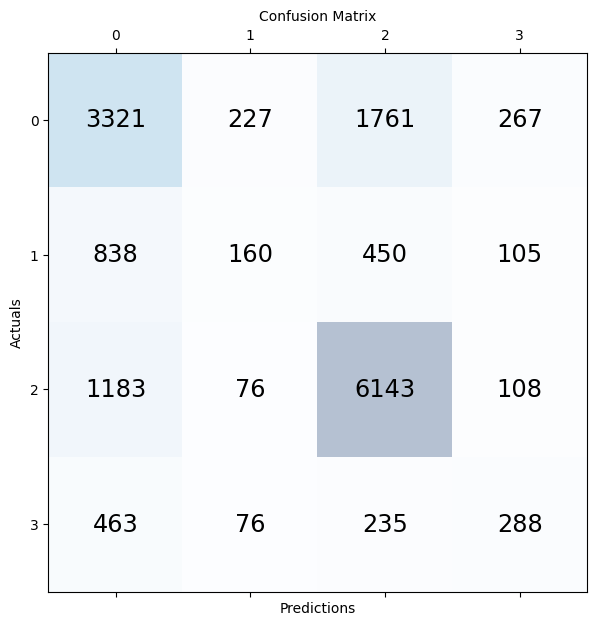

In [15]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', best_model.named_steps['feature_selection']),
    ('classifier', best_model.named_steps['classifier'])])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> ADASYN</span>

Fold number: 1, Training F1 Macro: 0.6080, Validation F1 Macro: 0.4342
Fold number: 2, Training F1 Macro: 0.5937, Validation F1 Macro: 0.4394
Fold number: 3, Training F1 Macro: 0.5975, Validation F1 Macro: 0.4366
Fold number: 4, Training F1 Macro: 0.6044, Validation F1 Macro: 0.4227
Fold number: 5, Training F1 Macro: 0.6016, Validation F1 Macro: 0.4344

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.55      0.38      0.45      5576
     Class 1       0.20      0.37      0.26      1553
     Class 2       0.76      0.69      0.72      7510
     Class 3       0.23      0.47      0.31      1062

    accuracy                           0.53     15701
   macro avg       0.43      0.48      0.43     15701
weighted avg       0.59      0.53      0.55     15701

Confusion Matrix:


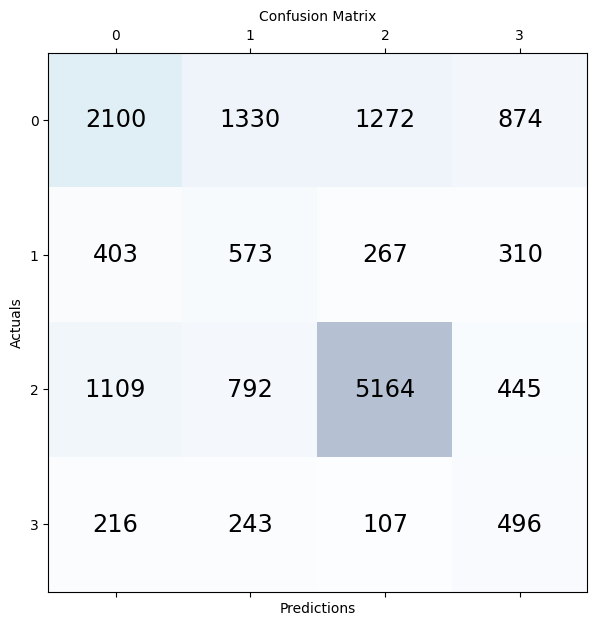

In [51]:
# Define the SMOTE object
smote=ADASYN(random_state=42, sampling_strategy='not majority')

model= LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('smote', smote), 
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + CHI-2 FEATURE SELECTION </span>

Fold number: 1, Training F1 Macro: 0.5382, Validation F1 Macro: 0.4819
Fold number: 2, Training F1 Macro: 0.5291, Validation F1 Macro: 0.4917
Fold number: 3, Training F1 Macro: 0.5327, Validation F1 Macro: 0.4972
Fold number: 4, Training F1 Macro: 0.5357, Validation F1 Macro: 0.4960
Fold number: 5, Training F1 Macro: 0.5340, Validation F1 Macro: 0.5109

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.50      0.55      5576
     Class 1       0.32      0.21      0.25      1553
     Class 2       0.74      0.83      0.78      7510
     Class 3       0.32      0.52      0.39      1062

    accuracy                           0.63     15701
   macro avg       0.50      0.52      0.50     15701
weighted avg       0.63      0.63      0.62     15701

Confusion Matrix:


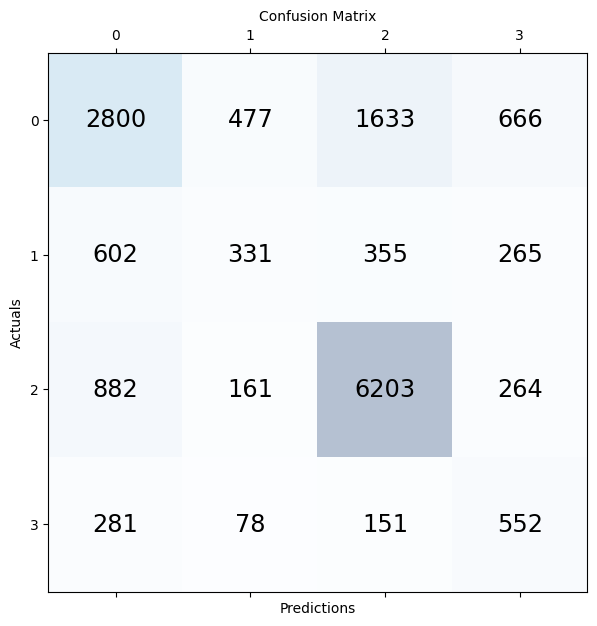

In [28]:
params={'penalty': 'l1', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.1}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectKBest(score_func=chi2, k=1042)), # 600
    ('classifier', model)])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE + CLASS WEIGHTS + CHI-2 FEATURE SELECTION </span>

Fold number: 1, Training F1 Macro: 0.5459, Validation F1 Macro: 0.4709
Fold number: 2, Training F1 Macro: 0.5332, Validation F1 Macro: 0.4686
Fold number: 3, Training F1 Macro: 0.5391, Validation F1 Macro: 0.4660
Fold number: 4, Training F1 Macro: 0.5460, Validation F1 Macro: 0.4625
Fold number: 5, Training F1 Macro: 0.5434, Validation F1 Macro: 0.4680

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.39      0.48      5576
     Class 1       0.23      0.34      0.27      1553
     Class 2       0.77      0.78      0.77      7510
     Class 3       0.26      0.54      0.35      1062

    accuracy                           0.58     15701
   macro avg       0.47      0.51      0.47     15701
weighted avg       0.62      0.58      0.59     15701

Confusion Matrix:


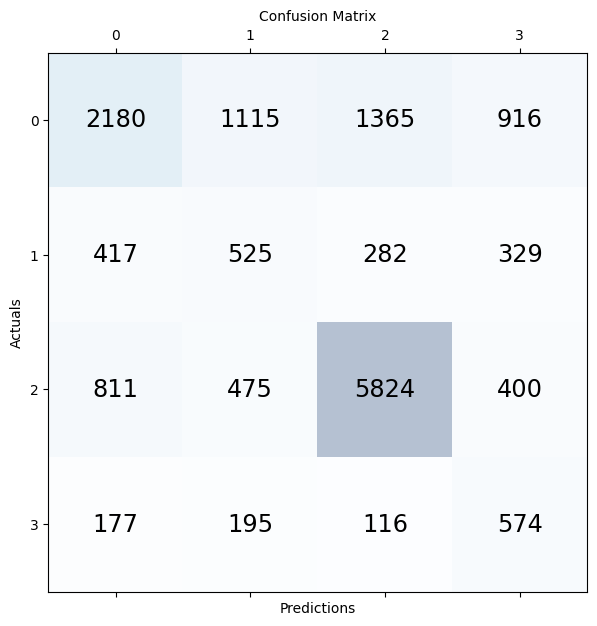

In [29]:
params={'penalty': 'l1', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': False, 'C': 0.1}
model= LinearSVC(class_weight='balanced',random_state=42, **params)

# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('vectorizer', vectorizer),
    ('feature_selection', SelectKBest(score_func=chi2, k=1042)), # 600
    ('smote', smote), 
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_selected, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])